# Getting Started

This notebook will get you off and running working with the Strava dataset. It assumes that you have the Strava dataset loaded and running in a local MongoDB database named `strava`.

In [1]:
!pip install --user pymongo
!pip install --user geopy
!pip install --user matplotlib

# this next command will likely fail unless you run one of the following:
# sudo apt install -y geos libgeos-dev
# sudo yum install -y geos-devel
# `conda install geos` works on Windows if you're working from Anaconda like you should be

# I installed using "conda install geos" on my windows box, and then had to set this to get basemap to pick it up:
%env GEOS_DIR=C:\\Users\\dnelson\\Anaconda3\\Library
    
!pip install --user https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
    
%matplotlib inline

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


env: GEOS_DIR=C:\\Users\\dnelson\\Anaconda3\\Library


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Using matplotlib backend: Qt5Agg


If the following cell can't import `pymongo`, go to `Kernel` -> `Restart and Run All`. After freshly installing a package using pip (as in the cell above), the kernel needs to restart to pick up the newly installed package.

In [2]:
import pymongo
client = pymongo.MongoClient()
db = client.strava
num_users = db['users'].estimated_document_count()
num_routes = db['routes'].estimated_document_count()
num_segments = db['segments'].estimated_document_count()

print("The database contains {} users, {} routes, and {} segments.".format(num_users,num_routes,num_segments))

The database contains 15441918 users, 41736 routes, and 1949655 segments.


In [3]:
users = db['users']
import pprint
pprint.pprint(users.index_information())

{'_id_': {'key': [('_id', 1)], 'ns': 'strava.users', 'v': 1},
 'user_id_1': {'key': [('user_id', 1.0)],
               'ns': 'strava.users',
               'unique': True,
               'v': 1}}


Unfortunately, we're working with too many documents here to do things the usual MongoDB way - trying to call `users.distinct("location")` will cause Mongo to overload and give up!

This means we'll have to make heavy use of the aggregate function. Some examples are below - note that they might take a couple of minutes to run.

Essentially, what we're doing here is building a set of steps for Mongo to follow, in the form of the pipeline, and then telling Mongo to get back to us with the results when it's done.

Here's a list of the operations permitted in the pipeline: https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/

In [4]:
count_pipeline = [
    {"$group": {"_id": '$location', "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 100} # without this limit, Jupyter has a hard time handling all the output!
]

# Feel free to try the following line and see the error it throws:
#users.distinct("location").limit(10)

import pprint
top_100_locations = list(db.users.aggregate(count_pipeline))
pprint.pprint(top_100_locations)

[{'_id': None, 'count': 5153642},
 {'_id': 'London, United Kingdom', 'count': 88626},
 {'_id': 'Valli Del Pasubio, Veneto, Italia', 'count': 58989},
 {'_id': 'London, England, United Kingdom', 'count': 58985},
 {'_id': 'United Kingdom', 'count': 35273},
 {'_id': 'São Paulo, São Paulo, Brazil', 'count': 34507},
 {'_id': 'San Francisco, CA', 'count': 33209},
 {'_id': 'Seoul, South Korea', 'count': 32557},
 {'_id': 'Singapore, Singapore', 'count': 27366},
 {'_id': 'Los Angeles, CA', 'count': 24369},
 {'_id': 'New York, NY', 'count': 23893},
 {'_id': 'Paris, Île-de-France, France', 'count': 17598},
 {'_id': 'San Francisco, California', 'count': 17361},
 {'_id': 'San Diego, CA', 'count': 16832},
 {'_id': 'Oslo, Oslo, Norway', 'count': 16527},
 {'_id': 'Brasília, Distrito Federal, Brazil', 'count': 16500},
 {'_id': 'Taiwan', 'count': 16363},
 {'_id': 'Cape Town, Western Cape, South Africa', 'count': 16228},
 {'_id': 'Santiago, Santiago Metropolitan Region, Chile', 'count': 16171},
 {'_id': '

In [24]:
# now let's see them on a map
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="running_data_rectifier")
map_locations = []
for location in top_100_locations[1:]: # skip the first location, since it's "none"
    result = geolocator.geocode(location['_id'])
    if result == None or result.latitude == None or result.latitude == None:
        print("Location \"{}\" does not geocode - skipping!".format(location))
    else:
        coded_location = {'lat': result.latitude, 'lng': result.longitude, 'count': location['count']}
    map_locations.append(coded_location)
    
pprint.pprint(map_locations)

Location "{'_id': 'Paris, IDF, France', 'count': 6505}" does not geocode - skipping!
[{'count': 88626, 'lat': 51.5073219, 'lng': -0.1276474},
 {'count': 58989, 'lat': 45.7407742, 'lng': 11.262167},
 {'count': 58985, 'lat': 51.5073219, 'lng': -0.1276474},
 {'count': 35273, 'lat': 54.7023545, 'lng': -3.2765753},
 {'count': 34507, 'lat': -23.5506507, 'lng': -46.6333824},
 {'count': 33209, 'lat': 45.4149778, 'lng': -72.749396},
 {'count': 32557, 'lat': 37.5666791, 'lng': 126.9782914},
 {'count': 27366, 'lat': 1.3408528, 'lng': 103.878446863736},
 {'count': 24369, 'lat': 34.0536834, 'lng': -118.2427669},
 {'count': 23893, 'lat': 40.7308619, 'lng': -73.9871558},
 {'count': 17598, 'lat': 48.85881005, 'lng': 2.32003101155031},
 {'count': 17361, 'lat': 37.7647993, 'lng': -122.4629897},
 {'count': 16832, 'lat': 32.7174209, 'lng': -117.1627714},
 {'count': 16527, 'lat': 59.9133301, 'lng': 10.7389701},
 {'count': 16500, 'lat': -15.7934036, 'lng': -47.8823172},
 {'count': 16363, 'lat': 23.59829785,

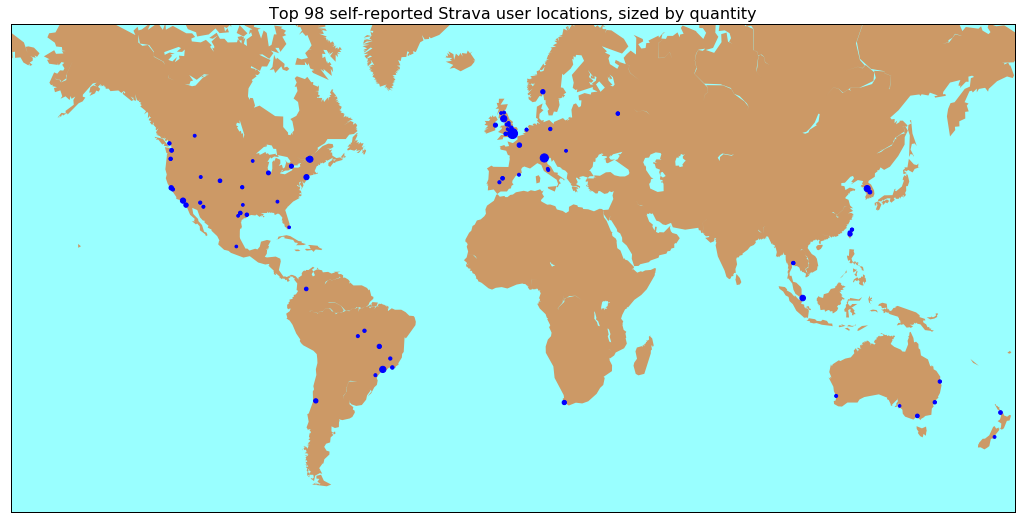

In [39]:
%matplotlib inline
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
lats = [loc['lat'] for loc in map_locations]
lons = [loc['lng'] for loc in map_locations]
max_count = max([loc['count'] for loc in map_locations])
normalized_count = [(float(loc['count']) / float(max_count))*100 for loc in map_locations]
# if you get "DLL load failed: the specified module could not be found", try this: https://blog.straywarrior.com/179.html

# draw map with markers
plt.figure(figsize=(18,10))
m = Basemap(projection='merc', llcrnrlon=-180, llcrnrlat=-60, urcrnrlon=180, urcrnrlat=70)
x, y = m(lons,lats)
m.scatter(x,y,normalized_count,marker='o',color='blue',zorder=10)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
plt.title("Top 98 self-reported Strava user locations, sized by quantity",fontsize=16)
plt.width = "10cm"
plt.show()